In [2]:
# import os
# os.environ['http_proxy'] = 'http://127.0.0.1:7890'
# os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [1]:
from IPython.display import Image

- Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks
    - https://arxiv.org/abs/1908.10084
    - https://www.sbert.net/index.html
- reference
    - https://www.pinecone.io/learn/series/nlp/train-sentence-transformers-softmax/
    - https://www.pinecone.io/learn/series/nlp/domain-transfer/

In [4]:
from sentence_transformers import losses

/root/miniconda3/envs/nlp_study/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Sentence level tasks

- NLI (natural language inferencing): 句子间关系
    - This task receives two input sentences (pair) and outputs either “entailment”, “contradiction” or “neutral”.
    - entailment: sentence1 entails sentence 2，蕴含；
    - contradiction: sentence1 contradicts sentence2，矛盾；
    - neutral: the two sentences have no relation，中立；
- STS (sentence textual similarity):
    - This task receives two sentences and decides the similarity of them. Often similarity is calculated using cosine similarity function.

## Demos

- `paraphrase-MiniLM-L6-v2`
    - embedding dimension：384 = 32*12
    - 判断两个句子是否是互为释义（即是否含有相同的意义）。

```
from sentence_transformers import SentenceTransformer, util
embed_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embed_1 = embed_model.encode(sentence1, convert_to_tensor=True)
embed_2 = embed_model.encode(sentence2, convert_to_tensor=True)
cos_sim = util.pytorch_cos_sim(embed_1, embed_2).item()
```

In [5]:
from sentence_transformers import SentenceTransformer, util

embed_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embed_1 = embed_model.encode('the movie is great!', convert_to_tensor=True)

embed_2 = embed_model.encode('positive', convert_to_tensor=True)
cos_sim = util.pytorch_cos_sim(embed_1, embed_2).item()
print(cos_sim)

embed_3 = embed_model.encode('negative', convert_to_tensor=True)
cos_sim = util.pytorch_cos_sim(embed_1, embed_3).item()
print(cos_sim)

0.18069258332252502
-0.12082747370004654


## Models

### BERT

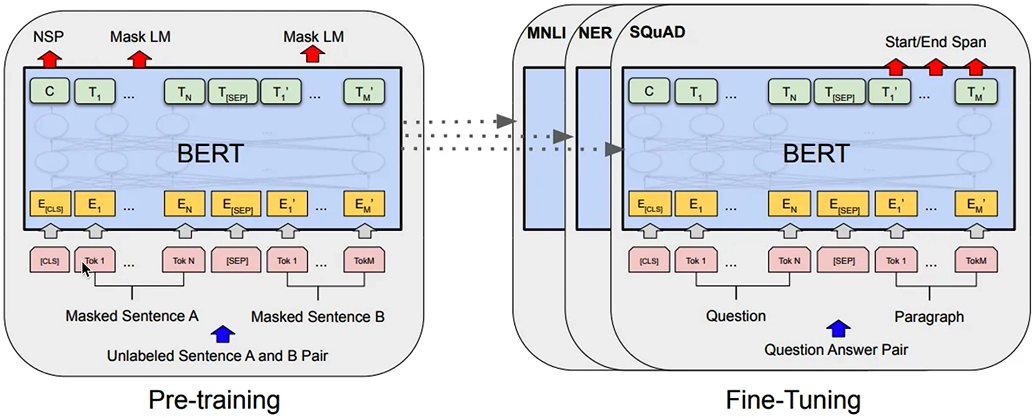

In [6]:
Image('imgs/bert_paradigm.png', width=800)

- BERT is very good at learning the meaning of words/tokens.
    - But It is **not good at learning meaning of sentences**.
    - Sentence classification, sentence pair-wise similarity.
- BERT produces token embedding, one way to get sentence embedding out of BERT is to average the embedding of all tokens. 
    - SentenceTransformer paper showed this produces very low quality sentence embeddings almost as bad as getting GLOVE embeddings. These embeddings do not capture the meaning of sentences.

### Training BERT on NLI (classification objective)

Siamese network. Siamese means twins and it consists of two networks of the exact same architecture that they share weight too.

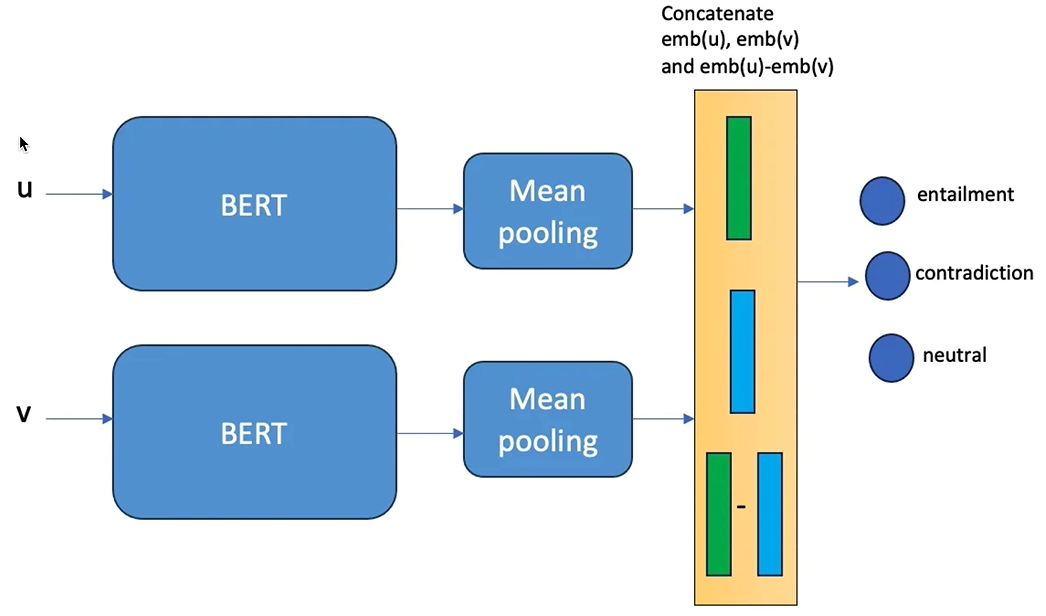

In [7]:
Image('imgs/bert_nli.png', width=600)

- sentence u => `emb(u)` (768d)
- sentence v => `emb(v)` (768d)
- `emb(u)-emb(v)` (768d)
- $ output=\text{softmax}(W_t(u,v,u-v)) $
- calculate cross entropy loss.

> 注意，上图中的 u 和 v 经过的 BERT 和 Mean pooling 均为同一份（使用同一份内存空间）

### Training BERT on STS (regression objective)

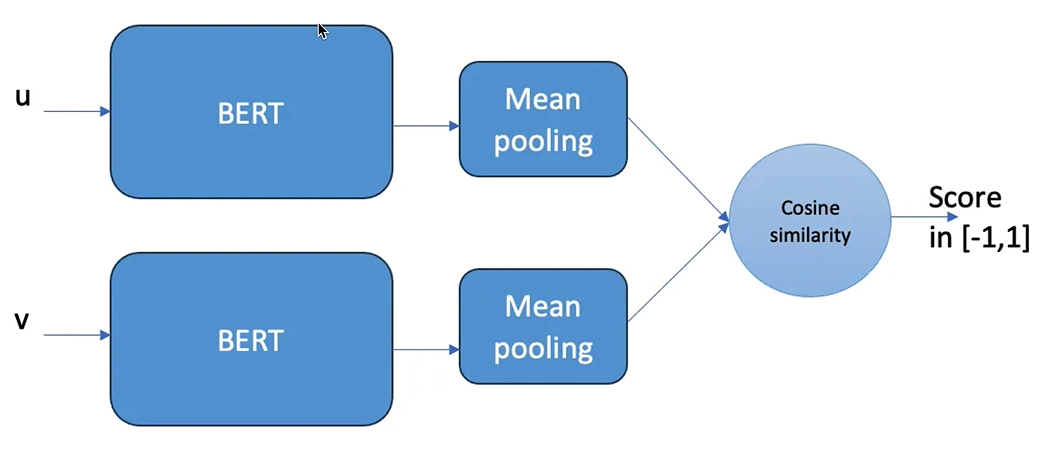

In [8]:
Image('imgs/bert_sts.png', width=600)

- Sentence textual similarity task receives two sentences and computes their similarity. 
- The network architecture for fine-tuning BERT on STS is as following. It is again a **siamese network with mean pooling on top**.

### Training BERT on Triplet dataset (triplet objective)

In [2]:
Image(url='imgs/bert_triplet.png', width=600)


To collect this data in text domain, we can pick a random sentence from a document as anchor, pick its following sentence as positive and pick a random sentence from a different passage as negative.

- In triplet objective, the model receives an anchor data point, 
- a positive data point that is related or close to the anchor, 
- and a negative data point that is unrelated to the anchor.

$$
|a-p|\lt |a-n|\\
L: = \max (0, |a-p|-|a-n|+\epsilon)\\
|a-p| \leq |a-m|-\epsilon\\
\Downarrow \\
L=0
$$ 

## Pretrain

### 模型

In [10]:
from sentence_transformers import SentenceTransformer, models

In [11]:
word_embed_model = models.Transformer('bert-base-uncased')
# a pool function over the token embeddings
pooling_model = models.Pooling(word_embed_model.get_word_embedding_dimension(), 
                               pooling_mode = 'cls',
                               pooling_mode_cls_token=True, 
                               pooling_mode_mean_tokens = False)
model = SentenceTransformer(modules=[word_embed_model, pooling_model])

In [12]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [13]:
word_embed_model.tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [14]:
word_embed_model.tokenizer.encode('hello world')

[101, 7592, 2088, 102]

In [15]:
print(word_embed_model.tokenizer.decode(101), word_embed_model.tokenizer.decode(102))

[CLS] [SEP]


### 数据集与任务

In [16]:
from datasets import load_dataset

# https://huggingface.co/datasets/glue/viewer/mrpc
# GLUE（General Language Understanding Evaluation）基准的一部分
# 名为 MRPC（Microsoft Research Paraphrase Corpus），Paraphrase：
# 判断两个句子是否是互为释义（即是否含有相同的意义）。
dataset = load_dataset("glue", "mrpc")

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [18]:
dataset['train']

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 3668
})

In [19]:
dataset['train'][8]

{'sentence1': 'That compared with $ 35.18 million , or 24 cents per share , in the year-ago period .',
 'sentence2': 'Earnings were affected by a non-recurring $ 8 million tax benefit in the year-ago period .',
 'label': 0,
 'idx': 8}

In [20]:
# texts/label/guid
from sentence_transformers import InputExample

In [21]:
training_ds = []
for example in dataset['train']:
    training_ds.append(InputExample(texts=[example['sentence1'], example['sentence2']],
                                    label=float(example['label'])))

In [22]:
from torch.utils.data import DataLoader
train_loader = DataLoader(training_ds, shuffle=True, batch_size=8)

In [23]:
import math

# batch 的数量
print(len(train_loader))
print(math.ceil(len(training_ds) / 8))

459
459


### 损失函数

In [24]:
train_examples = [
    InputExample(texts=['This is a positive pair', 'Where the distance will be minimized'], label=1),
    InputExample(texts=['This is a negative pair', 'Their distance will be increased'], label=0)
]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2)

In [25]:
len(train_dataloader)

1

In [26]:
train_examples[0]

In [27]:
from sentence_transformers import losses

In [28]:
losses.ContrastiveLoss??

Init signature:
losses.ContrastiveLoss(
    model: 'SentenceTransformer',
    distance_metric=<function SiameseDistanceMetric.<lambda> at 0x7fd54c981940>,
    margin: 'float' = 0.5,
    size_average: 'bool' = True,
) -> 'None'
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__i

In [29]:
train_loss = losses.ContrastiveLoss(model=model)

In [30]:
model.device

device(type='cuda', index=0)

In [31]:
model.encode??

Signature:
model.encode(
    sentences: 'str | list[str]',
    prompt_name: 'str | None' = None,
    prompt: 'str | None' = None,
    batch_size: 'int' = 32,
    show_progress_bar: 'bool | None' = None,
    output_value: "Literal[('sentence_embedding', 'token_embeddings')] | None" = 'sentence_embedding',
    precision: "Literal[('float32', 'int8', 'uint8', 'binary', 'ubinary')]" = 'float32',
    convert_to_numpy: 'bool' = True,
    convert_to_tensor: 'bool' = False,
    device: 'str' = None,
    normalize_embeddings: 'bool' = False,
    **kwargs,
) -> 'list[Tensor] | np.ndarray | Tensor'
Source:   
    def encode(
        self,
        sentences: str | list[str],
        prompt_name: str | None = None,
        prompt: str | None = None,
        batch_size: int = 32,
        show_progress_bar: bool | None = None,
        output_value: Literal["sentence_embedding", "token_embeddings"] | None = "sentence_embedding",
        precision: Literal["float32", "int8", "uint8", "binary", "ubinary

### 模型训练

In [32]:
from sentence_transformers import util
from tqdm import tqdm

# 计算测试集上的精确度
def test_acc():
    correct = 0
    for row in tqdm(dataset['test']):
        u = model.encode(row['sentence1'])
        v = model.encode(row['sentence2'])
        cos_score = util.cos_sim(u, v)[0].numpy()[0]
        if cos_score > 0.5 and row['label'] == 1:
            correct += 1
        if cos_score <= 0.5 and row['label'] == 0:
            correct += 1
    return correct / len(dataset['test'])

In [33]:
# 未训练前的效果
test_acc()

100%|██████████| 1725/1725 [00:30<00:00, 56.79it/s]


0.664927536231884

In [34]:
from sentence_transformers import evaluation

In [35]:
s1s = []
s2s = []
scores = []
for example in dataset['validation']:
    s1s.append(example['sentence1'])
    s2s.append(example['sentence2'])
    scores.append(float(example['label']))
evaluator = evaluation.BinaryClassificationEvaluator(s1s, s2s, scores)

In [36]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Start training
model.fit(
    train_objectives=[(train_loader, train_loss)], 
    evaluator=evaluator,
    evaluation_steps=500,
    epochs=5, 
    warmup_steps=0,
    output_path='./sentence_transformer/',
    weight_decay=0.01,
    optimizer_params={'lr': 0.00004},
    save_best_model=True,
    show_progress_bar=True,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for lo

Step,Training Loss,Validation Loss,Cosine Accuracy,Cosine Accuracy Threshold,Cosine F1,Cosine F1 Threshold,Cosine Precision,Cosine Recall,Cosine Ap,Dot Accuracy,Dot Accuracy Threshold,Dot F1,Dot F1 Threshold,Dot Precision,Dot Recall,Dot Ap,Manhattan Accuracy,Manhattan Accuracy Threshold,Manhattan F1,Manhattan F1 Threshold,Manhattan Precision,Manhattan Recall,Manhattan Ap,Euclidean Accuracy,Euclidean Accuracy Threshold,Euclidean F1,Euclidean F1 Threshold,Euclidean Precision,Euclidean Recall,Euclidean Ap,Max Accuracy,Max Accuracy Threshold,Max F1,Max F1 Threshold,Max Precision,Max Recall,Max Ap
459,No log,No log,0.803922,0.838763,0.870550,0.827297,0.793510,0.964158,0.911713,0.752451,102.270767,0.842924,101.164757,0.744505,0.971326,0.728024,0.813725,142.662079,0.871622,142.662079,0.824281,0.924731,0.913885,0.811275,6.486366,0.872964,6.759667,0.800000,0.960573,0.914203,0.813725,142.662079,0.872964,142.662079,0.824281,0.971326,0.914203
500,0.022300,No log,0.818627,0.865824,0.874587,0.826190,0.810398,0.949821,0.911330,0.759804,106.064789,0.843450,106.064789,0.760807,0.946237,0.739588,0.808824,146.756805,0.866438,146.756805,0.829508,0.906810,0.910685,0.811275,6.613691,0.867925,6.613691,0.832237,0.906810,0.910828,0.818627,146.756805,0.874587,146.756805,0.832237,0.949821,0.911330
918,0.022300,No log,0.830882,0.884139,0.881647,0.873137,0.845395,0.921147,0.918311,0.745098,92.875999,0.840491,92.875999,0.734584,0.982079,0.743778,0.821078,136.838440,0.878689,153.274445,0.809668,0.960573,0.920770,0.821078,6.359122,0.877419,7.431373,0.797654,0.974910,0.920843,0.830882,136.838440,0.881647,153.274445,0.845395,0.982079,0.920843
1000,0.010900,No log,0.835784,0.864161,0.885077,0.864161,0.848684,0.924731,0.923886,0.762255,103.509117,0.849231,92.974945,0.743935,0.989247,0.769480,0.825980,134.460968,0.877375,134.460968,0.846667,0.910394,0.925024,0.825980,6.164149,0.877797,6.164149,0.844371,0.913978,0.924911,0.835784,134.460968,0.885077,134.460968,0.848684,0.989247,0.925024
1377,0.010900,No log,0.838235,0.905216,0.882155,0.857183,0.831746,0.939068,0.924229,0.757353,89.414696,0.846512,89.414696,0.745902,0.978495,0.751174,0.828431,120.141891,0.883333,137.228012,0.825545,0.949821,0.923700,0.830882,6.260060,0.885191,6.260060,0.826087,0.953405,0.923533,0.838235,120.141891,0.885191,137.228012,0.831746,0.978495,0.924229
1500,0.005300,No log,0.838235,0.851918,0.885813,0.851918,0.856187,0.917563,0.921862,0.776961,99.941818,0.852989,99.941818,0.776471,0.946237,0.769339,0.833333,135.071808,0.882155,156.125885,0.831746,0.939068,0.923851,0.833333,6.109689,0.882155,6.968035,0.831746,0.939068,0.923889,0.838235,135.071808,0.885813,156.125885,0.856187,0.946237,0.923889
1836,0.005300,No log,0.843137,0.887519,0.888502,0.887519,0.864407,0.913978,0.925859,0.764706,87.368454,0.850467,87.368454,0.752066,0.978495,0.771752,0.833333,108.069000,0.881533,117.413437,0.857627,0.906810,0.926203,0.835784,4.869046,0.882662,5.286923,0.863014,0.903226,0.926385,0.843137,108.069000,0.888502,117.413437,0.864407,0.978495,0.926385
2000,0.003000,No log,0.838235,0.867325,0.886207,0.863449,0.853821,0.921147,0.921584,0.757353,92.558640,0.845679,86.831848,0.742547,0.982079,0.772522,0.828431,120.862503,0.877888,160.036377,0.813456,0.953405,0.923598,0.825980,5.348031,0.876442,7.343032,0.810976,0.953405,0.923636,0.838235,120.862503,0.886207,160.036377,0.853821,0.982079,0.923636
2295,0.003000,No log,0.845588,0.878238,0.890815,0.876902,0.862416,0.921147,0.925270,0.762255,87.944992,0.849145,87.018822,0.750000,0.978495,0.773408,0.843137,119.687881,0.886525,119.687881,0.877193,0.896057,0.926421,0.840686,5.437978,0.884956,5.437978,0.874126,0.896057,0.926532,0.845588,119.687881,0.890815,119.687881,0.877193,0.978495,0.926532


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [37]:
# batch 总数计算
math.ceil(3668 / 8) * 5

2295

### 测试效果

In [38]:
sentences = ['This is just a random sentence on a friday evenning', 
             'to test model ability.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

print(embeddings)

[[ 0.24573915 -0.05806259 -0.03596918 ... -0.09078896  0.03773675
   0.23377846]
 [ 0.17040366  0.09887939 -0.03471823 ... -0.47442475 -0.01734467
  -0.19222575]]


In [39]:
# 训练后的效果
test_acc()

100%|██████████| 1725/1725 [00:29<00:00, 58.19it/s]


0.7130434782608696